In [0]:
import sys
sys.version

%reset -f
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'
import sys
sys.version

!pip3 install 'torch==0.4.0'
!pip3 install 'torchvision==0.2.1'
!pip3 install --no-cache-dir -I 'pillow==5.1.0'
!pip3 install torchvision
!pip install 'livelossplot==0.2.2'
!pip install 'imageio==2.4.1'
!pip install  'torchnet==0.0.4'

print('done')
# Restart Kernel
# This workaround is needed to properly upgrade PIL on Google Colab.
import os
os._exit(0)

    100% |████████████████████████████████| 2.0MB 34.1MB/s 


In [1]:
from torch.utils.data import Dataset
from skimage import io, transform
from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image
import random 
import numpy as np
from torchvision import transforms, datasets
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
# from scipy.misc import imread 
from imageio import imread
import torch
from livelossplot import PlotLosses
from torch.utils.data import Dataset, DataLoader


Using TensorFlow backend.


In [2]:

print('__pyTorch VERSION:', torch.__version__)
use_cuda = torch.cuda.is_available()
print('use_cuda = {0}'.format(use_cuda))

DATA_FOLDER ='data'

SEED = 999

def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

fixSeed(SEED)

__pyTorch VERSION: 0.4.0
use_cuda = True


In [3]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"gabib3b","key":"66ec1c1397fd5cb0a1d4831d60f20a90"}'}

In [4]:
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/





kaggle.json


In [5]:
!kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset

v2-plant-seedlings-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:

!unzip -q v2-plant-seedlings-dataset.zip -d data

replace data/Black-grass/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [28]:
#!ls data
!pip install 'torchnet==0.0.4'

    100% |████████████████████████████████| 256kB 22.7MB/s 
    100% |████████████████████████████████| 204kB 24.1MB/s 
  Running setup.py bdist_wheel for torchnet ... - \ done
  Stored in directory: /root/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Running setup.py bdist_wheel for visdom ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fb/ef/d8/ad95fbafb505c507b476c4e907af570d2dd41ae725cdc9b391
  Running setup.py bdist_wheel for torchfile ... - done
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchnet visdom torchfile


In [26]:
image_size = 224
import torchnet

ModuleNotFoundError: ignored

In [27]:
!luarocks install torchnet


/bin/bash: luarocks: command not found


In [0]:
class DatasetLoader(Dataset):

    def __init__(self, df, transform):
        self._df = df
        self._transform = transform


    @staticmethod
    def find_classes(root_dir):

        labels_folders = os.listdir(root_dir)
        index_class = {}
        xs = []
        ys = []

        for index, label in enumerate(labels_folders):
            index_class[index] = label
            y_train_folder = os.path.join(root_dir, label)
            for file in os.listdir(y_train_folder):
                train_example_path = os.path.join(y_train_folder, file)
                xs.append([train_example_path, label, index])
                ys.append(index)

        df = pd.DataFrame(xs, columns=['file', 'category', 'category_id'])

        return  index_class, df


    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):
        current_element = self._df.iloc[idx]
        fullname = current_element['file']

        image = Image.open(fullname).convert('RGB')

        if self._transform:
            image = self._transform(image)

        label = current_element['category_id']

        return image, label

In [11]:
index_class, data_df = DatasetLoader.find_classes(DATA_FOLDER)
all_data = data_df.sample(frac=0.90)
test_data = data_df[~data_df['file'].isin(all_data['file'])]
train_data = all_data.sample(frac=0.80)
valid_data = all_data[~all_data['file'].isin(train_data['file'])]
print('trainning size  {0} validation size {1} test size {2}'.format(len(train_data),len(valid_data),len(test_data)))

trainning size  3988 validation size 997 test size 554


In [0]:

train_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor()
    ])


train_set = DatasetLoader(train_data, train_data_transform)

train_loader = DataLoader(train_set, batch_size=len(train_data), shuffle=True, num_workers=0)




pop_mean = []
pop_std0 = []
pop_std1 = []
for i, data in enumerate(train_loader, 0):
    # shape (batch_size, 3, height, width)
    numpy_image = data[0].numpy()
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std0 = np.std(numpy_image, axis=(0,2,3))
    
    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)

mean_rgb = np.array(pop_mean).mean(axis=0)
std_rgb = np.array(pop_std0).mean(axis=0)


# r_chanel = 0.0
# g_chanel = 0.0
# b_chanel = 0.0

# size = 0.0

# for images, _ in train_loader:
#   for img in images:
#     print(img)
#     break
  
#   break

    

# for images, _ in train_loader:
  
#   for img in images:
#     size += img.shape[0] * img.shape[1]
#     r_chanel += np.sum(img.numpy()[:,:, 0])
#     g_chanel += np.sum(img.numpy()[:, :, 1])
#     b_chanel += np.sum(img.numpy()[:, :, 2])

# r_mean = r_chanel /size
# g_mean = g_chanel /size
# b_mean = b_chanel /size
# print([r_mean, g_mean, b_mean])

# mean_calc_r = 0.0
# mean_calc_g = 0.0
# mean_calc_b = 0.0

# for images, _ in iter(train_loader):
  
#   for img in images:
  
#     mean_calc_r += np.sum(np.square(img.numpy()[:, :, 0] - r_mean))
#     mean_calc_g += np.sum(np.square(img.numpy()[:, :, 1] - g_mean))
#     mean_calc_b += np.sum(np.square(img.numpy()[:, :, 2] - b_mean))
    
# std_r = np.sqrt(mean_calc_r/(size))
# std_g = np.sqrt(mean_calc_g/(size))
# std_b = np.sqrt(mean_calc_b/(size-1))


# mean_rgb = [r_mean, g_mean, b_mean]

# std_rgb = [std_r, std_g, std_b]


    
    



In [53]:
(mean_rgb,std_rgb)

(array([0.32892254, 0.28883928, 0.20670748], dtype=float32),
 array([0.10283381, 0.10805346, 0.12497998], dtype=float32))

a
0
1
2
3


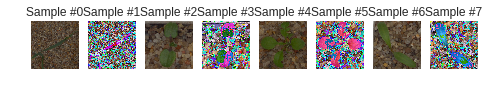

In [12]:
import matplotlib.pyplot as plt
imagesToShow = 4
mean_rgb = [0.485, 0.456, 0.406]
std_rgb =[0.229, 0.224, 0.225]


normalize_img = transforms.Normalize(mean=mean_rgb, std=std_rgb)


image_size = 224
# train_data_transform = transforms.Compose([ transforms.Resize(size=(image_size,image_size)), transforms.ToTensor(), normalize_img])

normalized_train_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        normalize_img
    ])


normalized_train_set = DatasetLoader(train_data, normalized_train_data_transform)

normalized_train_loader = DataLoader(normalized_train_set, batch_size=1, shuffle=True, num_workers=0)



def flaotTensorToImage(img, mean=0, std=1):
  """convert a tensor to an image"""
  img = np.transpose(img.numpy(), (1, 2, 0))
  img = (img*std+ mean)*255
  img = img.astype(np.uint8)    
  return img   

print('a')

imageINdex = 0
for i, data in enumerate(normalized_train_loader, 0):
  
  print(i)
  images, labels = data            
  image=images[0]
  
  ax = plt.subplot(1, imagesToShow * 2, imageINdex + 1)
  ax.set_title('Sample #{}'.format(imageINdex))
  ax.axis('off')
  plt.imshow (flaotTensorToImage(image,mean_rgb,std_rgb))
  
  
  imageINdex += 1
  ax = plt.subplot(1, imagesToShow * 2, imageINdex + 1)
  ax.set_title('Sample #{}'.format(imageINdex))
  ax.axis('off')
  plt.imshow (flaotTensorToImage(image))
  imageINdex +=1
  

  if i==imagesToShow-1:
    break  
        
    

  
  

a


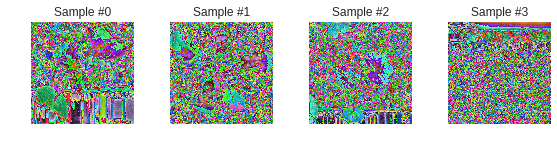

In [0]:
# import matplotlib.pyplot as plt
# imagesToShow = 4


# normalize_img = transforms.Normalize(mean=mean_rgb, std=std_rgb)


# image_size = 224
# # train_data_transform = transforms.Compose([ transforms.Resize(size=(image_size,image_size)), transforms.ToTensor(), normalize_img])

# normalized_train_data_transform = transforms.Compose([
#         transforms.Resize(size=(image_size,image_size)),
#         transforms.ToTensor(),
#         normalize_img
#     ])


# normalized_train_set = DatasetLoader(train_data, normalized_train_data_transform)

# normalized_train_loader = DataLoader(normalized_train_set, batch_size=1, shuffle=True, num_workers=0)



# def flaotTensorToImage(img, mean=0, std=1):
#   """convert a tensor to an image"""
#   img = np.transpose(img.numpy(), (1, 2, 0))
#   img = (img*std+ mean)*255
#   img = img.astype(np.uint8)    
#   return img   

# print('a')

# for i, data in enumerate(normalized_train_loader, 0):
  
#   #print(999)
#   images, labels = data            
#   #num = len(images)
#   image=images[n]
  
  
#   ax = plt.subplot(1, imagesToShow, i + 1)
  
#   plt.tight_layout()
#   ax.set_title('Sample #{}'.format(i))
#   ax.axis('off')
  
#   plt.imshow (flaotTensorToImage(image))
  
 

#   if i==imagesToShow-1:
#     break  
        
    

  
  

In [0]:
from torch.utils.data import Dataset, DataLoader

hidden_size = 500  
num_classes = 12  
num_epochs = 100  
momentum = 0.9
batch_size = 8 
learning_rate = 0.001

input_size = image_size * image_size * 3 


# pop_std0,pop_mean


normalize_img_trabnsform = transforms.Normalize(mean=mean_rgb,
                                     std=std_rgb)



train_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor()
    ])

train_data_transform_with_normalization = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        normalize_img_trabnsform
    ])
	
  
valid_data_transform_with_normalization = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        normalize_img_trabnsform
    ])
	
  
valid_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor()
    ])

test_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        normalize_img_trabnsform
    ])
	


train_set = DatasetLoader(train_data, train_data_transform)
train_set_with_notmalization = DatasetLoader(train_data, train_data_transform_with_normalization)


valid_set_with_normalization = DatasetLoader(valid_data, valid_data_transform_with_normalization)
valid_set = DatasetLoader(valid_data, valid_data_transform)
test_set = DatasetLoader(test_data, test_data_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
train_loader_with_normalization = DataLoader(train_set_with_notmalization, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader_with_normalization = DataLoader(valid_set_with_normalization, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)





    

torch.Size([1, 3, 224, 224])

In [15]:
print(batch_size)

8


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


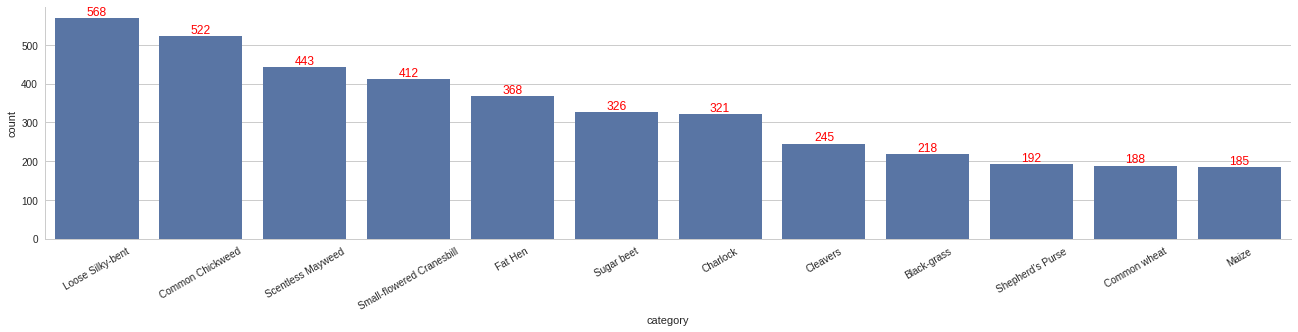

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

g = sns.factorplot("category", data=train_data, aspect=4.5, kind="count", color="b", order = train_data['category'].value_counts().index)
g.set_xticklabels(rotation=30)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='red', ha='center', va='bottom')




/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


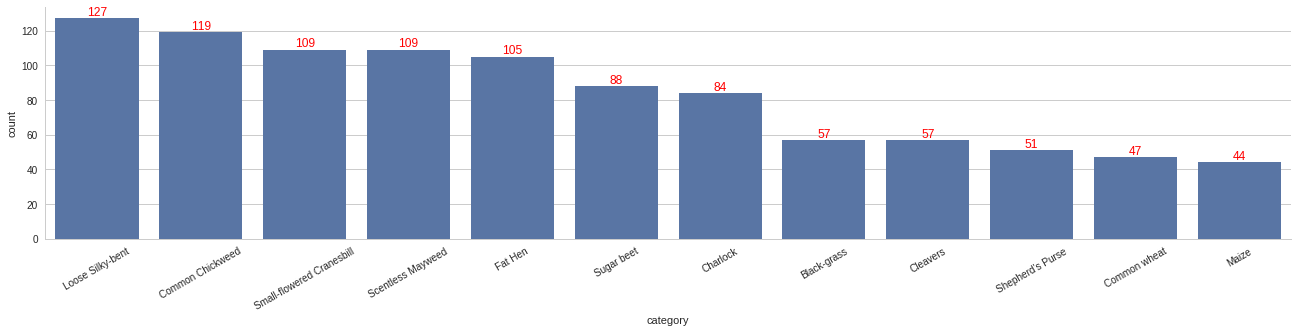

In [15]:
sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

g = sns.factorplot("category", data=valid_data, aspect=4.5, kind="count", color="b",  order = valid_data['category'].value_counts().index)
g.set_xticklabels(rotation=30)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='red', ha='center', va='bottom')



In [0]:
class NetA(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NetA, self).__init__()  # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
        self.relu = nn.ReLU()  # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = nn.Linear(hidden_size,
                             num_classes)  # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)

    def forward(self, x):  # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
            

class LeNet(nn.Module):
    def __init__(self, num_classes=12, num_rgb=3):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(num_rgb, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        # print(out.data.size())
        n1 = self.num_flat_features(out)
        out = out.view(-1, n1)
        #out = out.view(n1, -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        
        
        
#         out = out.view(out.size(0), -1)
        # print(out.data.size())
        out = self.fc3(out)
        return out
    
    def num_flat_features(self, x):
      size = x.size()[1:]
      num_features = 1
      for s in size:
        num_features *= s
      return num_features
      

In [17]:
# from torch.utils.data import Dataset, DataLoader

# hidden_size = 500  
# num_classes = 12  
# num_epochs = 100  
# momentum = 0.9
# batch_size = 8 
# learning_rate = 0.001

# input_size = image_size * image_size * 3 




# normalize_img = transforms.Normalize(mean=[mean_calc_r, mean_calc_g, mean_calc_g],
#                                      std=[std_r, std_g, std_b])


# train_data_transform = transforms.Compose([
#         transforms.Resize(size=(image_size,image_size)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])
	
  
# valid_data_transform = transforms.Compose([
#         transforms.Resize(size=(image_size,image_size)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])
	
  
# test_data_transform = transforms.Compose([
#         transforms.Resize(size=(image_size,image_size)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])
	


# train_set = DatasetLoader(train_data, train_data_transform)
# valid_set = DatasetLoader(valid_data, valid_data_transform)
# test_set = DatasetLoader(test_data, test_data_transform)

# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
# validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
print(input_size)




150528


In [0]:

# import matplotlib.pyplot as plt
# import numpy as np
# import torchvision


# def imshow(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

    

# dataiter = iter(train_loader)
 
# images, labels = next(dataiter)

# imshow(torchvision.utils.make_grid(images))

      

In [17]:

liveloss = PlotLosses()


neta = NetA(input_size, hidden_size, num_classes)


print(neta)
if use_cuda:
    print('use coda')
    model = neta.cuda()
else:
    print('dont use coda')
    model = neta

model = torch.nn.DataParallel(model, device_ids=list(range(1)))    

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

if use_cuda:
  criterion.cuda()

print('use_cuda {0}'.format(use_cuda))
model.train()
print('b1')

for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    epoch_correct = 0.0
    epoch_incorrect = 0.0
    epoch_loss_val = 0.0
    epoch_correct_val = 0.0
    avg_loss_val = 0.0
    avg_accuracy_val = 0.0
    model.train()
    total = 0.0
    correct = 0.0
    for i, (images, labels) in enumerate(train_loader):  # Load a batch of images with its (index, data, class)
       
        if use_cuda and torch.cuda.is_available():
            images = images.view(-1, image_size * image_size * 3).cuda()
            labels = labels.cuda()
            images = Variable(images)  
            labels = Variable(labels)
        else:
          images = Variable(images.view(-1, image_size * image_size * 3))  
          labels = Variable(labels)
        
        optimizer.zero_grad()    
        
        outputs = model(images)  
        loss = criterion(outputs, labels)
        
        
        loss.backward() 
        optimizer.step()
                
        total += len(images)
        
        epoch_loss += loss.data[0]
        current_correct = (outputs.data.cpu().max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
        current_incorrect = (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
        epoch_incorrect += current_incorrect
        pred = outputs.data.max(1)[1] 
        correct += pred.eq(labels.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        epoch_correct += current_correct
        
    avg_loss = epoch_loss / len(train_loader.dataset)
    avg_accuracy = epoch_correct / (len(train_loader.dataset)*1.0)
    

    
    model.eval()
    for inputs, labels in validation_loader:
                
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.view(-1, image_size * image_size * 3).cuda()
            labels = labels.cuda()
            inputs = Variable(inputs)  
            labels = Variable(labels)
        else:
          inputs, labels = Variable(inputs.view(-1, image_size * image_size * 3)) , Variable(labels)
        
   
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        
        epoch_loss_val += loss.data[0]
        
        
        epoch_correct_val += (outputs.cpu().data.max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
    
    #print('epoch_correct_val = {0}'.format(epoch_correct_val))
    
    avg_loss_val = epoch_loss_val / len(validation_loader.dataset)
    avg_accuracy_val = epoch_correct_val / len(validation_loader.dataset)
    
    #print('avg_accuracy_val = {0}'.format(avg_accuracy_val))
    
    liveloss.update({
        'log loss': avg_loss,
        'val_log loss': avg_loss_val,
        'accuracy': avg_accuracy,
        'val_accuracy': avg_accuracy_val
    })
    
    liveloss.draw()
    
    
        

NetA(
  (fc1): Linear(in_features=150528, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=12, bias=True)
)
use coda
use_cuda True
b1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Process Process-1:
Process Process-4:
Process Process-3:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-f17bace6ab1c>", line 41, in <module>
    for i, (images, labels) in enumerate(train_loader):  # Load a batch of images with its (index, data, class)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/pyt

KeyboardInterrupt: ignored

In [0]:
def train(model, device, train_loader, optimizer, criterion):
  model.train()
  
  epoch_loss = 0.0
  epoch_correct = 0.0
  epoch_incorrect = 0.0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  avg_loss_val = 0.0
  avg_accuracy_val = 0.0
  model.train()
  total = 0.0
  correct = 0.0
    
  for i, (images, labels) in enumerate(train_loader):
    
    images = images.view(-1, image_size * image_size * 3).to(device)
    #images = images.to(device)
    labels = labels.to(device)
    images = Variable(images)  
    labels = Variable(labels)
    
    optimizer.zero_grad()    
    outputs = model(images)  
    _, pred = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels)
    loss.backward() 
    optimizer.step()
    #total += len(images)
    total+=outputs.data.shape[0]
    epoch_loss += loss.item() #loss.data[0]
    #current_correct = (outputs.data.cpu().max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
    current_correct =torch.sum(pred==labels.data).cpu().numpy().item()
    
    #current_incorrect = (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
    current_incorrect =torch.sum(pred !=labels.data).cpu().numpy().item()
    #print((current_correct,current_incorrect))
    
    epoch_incorrect += current_incorrect
    pred = outputs.data.max(1)[1] 
    correct += pred.eq(labels.data).cpu().sum()
    accuracy = 100. * correct / len(images)
    epoch_correct += current_correct
        
        
  avg_loss = epoch_loss / len(train_loader.dataset)
  avg_accuracy = epoch_correct / (len(train_loader.dataset)*1.0)
  #print('train')
  return avg_loss, avg_accuracy


In [0]:
def test(model, device, loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  
  with torch.no_grad():
    
    for inputs, labels in loader:
        
        
        inputs = inputs.view(-1, image_size * image_size * 3).to(device)
        labels = labels.to(device)
        inputs = Variable(inputs)  
        labels = Variable(labels)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss_val += loss.data[0]
        epoch_correct_val += (outputs.cpu().data.max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
        
  avg_loss_val = epoch_loss_val / len(loader.dataset)
  avg_accuracy_val = epoch_correct_val / len(loader.dataset)
  
  return avg_loss_val,avg_accuracy_val
    

                                                                                              
                                                                                              
                                                                                              

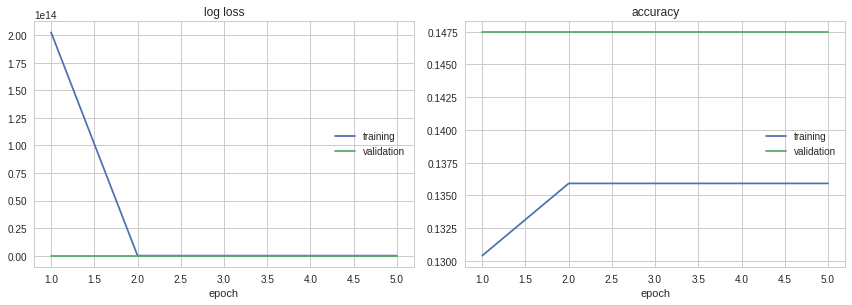

log loss:
training   (min:    0.303, max: 202499479935011.656, cur:    0.303)
validation (min:    0.302, max:    0.306, cur:    0.302)

accuracy:
training   (min:    0.130, max:    0.136, cur:    0.136)
validation (min:    0.147, max:    0.147, cur:    0.147)


KeyboardInterrupt: ignored

In [63]:
device = torch.device("cuda" if use_cuda else "cpu")

liveloss = PlotLosses()

model = NetA(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
# criterion.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(num_epochs):

  avg_loss, avg_accuracy = train(model, device, train_loader_with_normalization, optimizer, criterion)
  avg_loss_val,avg_accuracy_val = test(model, device, validation_loader_with_normalization, criterion)
  
  liveloss.update({
        'log loss': avg_loss,
        'val_log loss': avg_loss_val,
        'accuracy': avg_accuracy,
        'val_accuracy': avg_accuracy_val
    })
    
    
  liveloss.draw()
    
  

In [20]:
liveloss = PlotLosses()
from torchnet.meter import ConfusionMeter

trainning_confusion_matrix = ConfusionMeter(num_classes)
val_confusion_matrix = ConfusionMeter(num_classes)


model = NetA(input_size, hidden_size, num_classes).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=momentum)

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_correct = 0.0
  epoch_incorrect = 0.0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  avg_loss_val = 0.0
  avg_accuracy_val = 0.0
  model.train()
  total = 0.0
  correct = 0.0
  
  running_loss = 0.01
  calc_correct = 0.0
  calc_count = 0.0
  
  for i, (images, labels) in enumerate(train_loader):
    
    images = images.view(-1, image_size * image_size * 3).cuda()
    images = images.cuda()
    labels = labels.cuda()
    images = Variable(images)  
    labels = Variable(labels)
    
    optimizer.zero_grad() 
    outputs = model(images)  
    _, pred = torch.max(outputs.data, 1)
    calc_correct +=torch.sum(pred==labels.data).cpu().numpy().item()
    calc_count+=outputs.data.shape[0]
    
    loss = criterion(outputs, labels)
    loss.backward() 
    optimizer.step()
    
    
#     pred = pred.cpu().numpy()
#     labels = labels.data.cpu().numpy()
    
    trainning_confusion_matrix.add(pred, labels)
    
      
    print((pred, labels))
    
    running_loss += loss.item()
  
  
  model.eval()
  
  validation_running_loss = 0.0
  validation_correct = 0.0
  validation_calc_count = 0.0
  
  with torch.no_grad():
    for i, (images, labels) in enumerate(validation_loader):

      images = images.view(-1, image_size * image_size * 3).cuda()
      labels = labels.cuda()
      images = Variable(images)  
      labels = Variable(labels)

      outputs = model(images)  
      _, pred = torch.max(outputs.data, 1)
      validation_correct +=torch.sum(pred==labels.data).cpu().numpy().item()
      validation_calc_count+=outputs.data.shape[0]
      
      val_confusion_matrix.add(pred, labels)
      
#       pred = pred.cpu()
#       labels = labels.data.cpu()
      
#       print((pred, labels))
      
      validation_running_loss += loss.item()
  
  
  
  liveloss.update({
        'log loss': running_loss/calc_count,
        'val_log loss': validation_running_loss/validation_calc_count,
        'accuracy': calc_correct/calc_count,
        'val_accuracy': validation_correct/validation_calc_count
    })
    
  
  liveloss.draw()

SyntaxError: ignored

In [0]:
import torch.nn.functional as F
def train_conv(model, device, current_loader, optimizer, criterion):
  print(1)
  model.train()
  
  epoch_loss = 0.0
  epoch_correct = 0.0
  epoch_incorrect = 0.0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  avg_loss_val = 0.0
  avg_accuracy_val = 0.0
  model.train()
  total = 0.0
  correct = 0.0
    
  for i, (images, labels) in enumerate(current_loader):
    
    #images = images.view(-1, image_size * image_size * 3).to(device)
    images = images.to(device)
    labels = labels.to(device)
    images = Variable(images)  
    labels = Variable(labels)
    
    optimizer.zero_grad()    
    outputs = model(images)  
    loss = criterion(outputs, labels)
    loss.backward() 
    optimizer.step()
    total += len(images)
    #epoch_loss += loss.data.cpu().numpy().item()
    #print('loss.data = {0}'.format(loss.data[0].to(torch.device("cpu")).numpy().item()))
    epoch_loss += loss.data[0].to(torch.device("cpu")).numpy().item()
    #print(epoch_loss)
    
    #current_correct = (outputs.data.cpu().max(1)[1] == labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
    current_correct = (outputs.data.cpu().max(1)[1] == labels.data.cpu()).sum().item()
    current_incorrect = (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().item()
    #print('F={0}'.format(F.nll_loss(outputs, labels, reduction='sum').item()))
    if i %10 == 0:
      print('correct {0} current_incorrect ={1}'.format(current_correct, current_incorrect))
    #current_incorrect = (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().data[0].numpy().astype(np.float32)
    epoch_incorrect += current_incorrect
    pred = outputs.data.max(1)[1] 
    correct += pred.eq(labels.data).cpu().sum()
    accuracy = 100. * correct / len(images)
    epoch_correct += current_correct
        
  print(epoch_loss)      
  avg_loss = epoch_loss / len(current_loader.dataset)
  print(avg_loss)
  avg_accuracy = epoch_correct / (len(current_loader.dataset)*1.0)
  print('train')
  print(avg_accuracy)
  return avg_loss, avg_accuracy

In [0]:
def test_conv(model, device, loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  
  with torch.no_grad():
    
    for inputs, labels in loader:
        
        
#         inputs = inputs.view(-1, image_size * image_size * 3).to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = Variable(inputs)  
        labels = Variable(labels)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss_val += loss.data[0].to(torch.device("cpu")).numpy().item()
        #epoch_correct_val += (outputs.cpu().data.max(1)[1] == labels.data.cpu()).sum().item()
        epoch_correct_val +=  (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().item()
        
  avg_loss_val = epoch_loss_val / len(loader.dataset)
  avg_accuracy_val = epoch_correct_val / len(loader.dataset)
  
  return avg_loss_val,avg_accuracy_val
    

In [66]:
device = torch.device("cuda" if use_cuda else "cpu")

liveloss = PlotLosses()
model = LeNet(12, 3).to(device)
#model = NetB().to(device)
criterion = nn.CrossEntropyLoss().to(device)
#nn.CrossEntropyLoss()
# criterion.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(num_epochs):

  avg_loss, avg_accuracy = train_conv(model, device, train_loader, optimizer, criterion)
  avg_loss_val,avg_accuracy_val = test_conv(model, device, validation_loader, criterion)
  
  liveloss.update({
        'log loss': avg_loss,
        'val_log loss': avg_loss_val,
        'accuracy': avg_accuracy,
        'val_accuracy': avg_accuracy_val
    })
    
    
  liveloss.draw()

1


RuntimeError: ignored

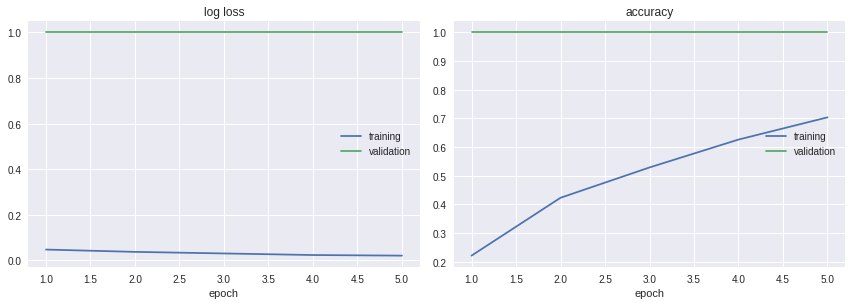

log loss:
training   (min:    0.021, max:    0.047, cur:    0.021)
validation (min:    1.000, max:    1.000, cur:    1.000)

accuracy:
training   (min:    0.221, max:    0.704, cur:    0.704)
validation (min:    1.000, max:    1.000, cur:    1.000)


Process Process-21:
Process Process-22:
Process Process-24:
Process Process-23:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-7-f17c9979f9f2>", line

KeyboardInterrupt: ignored

In [12]:
#trainning working
liveloss = PlotLosses()

model = LeNet()
model = model.cuda()
#criterion = nn.CrossEntropyLoss().cude()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=momentum)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_correct = 0.0
  epoch_incorrect = 0.0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  avg_loss_val = 0.0
  avg_accuracy_val = 0.0
  model.train()
  total = 0.0
  correct = 0.0
  
  running_loss = 0.01
  calc_correct = 0.0
  calc_count = 0.0
  
  for i, (images, labels) in enumerate(train_loader_with_normalization):
#     images = images.view(-1, image_size * image_size * 3).cuda()
    #images = images.unsqueeze(1)
    images = images.cuda()
    labels = labels.cuda()
    images = Variable(images)  
    labels = Variable(labels)
    
    optimizer.zero_grad() 
    outputs = model(images)  
    _, pred = torch.max(outputs.data, 1)
    calc_correct +=torch.sum(pred==labels.data).cpu().numpy().item()
#     print(calc_correct)
    calc_count+=outputs.data.shape[0]
    
    
    loss = criterion(outputs, labels)
    loss.backward() 
    optimizer.step()
    
    running_loss += loss.item()
    if i % 200 == 0:    # print every 2000 mini-batches
      #print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
    
    #if (i + 1) % 20 == 0:
      #print("Epoch = %d, Loss = %f" %(epoch, loss.data[0]))
      #current_correct = (outputs.data.cpu().max(1)[1] == labels.data.cpu()).sum().item()
      #current_incorrect = (outputs.data.cpu().max(1)[1] != labels.data.cpu()).sum().item()
      #print('correct {0} current_incorrect ={1}'.format(current_correct, current_incorrect))
      
  #pred = outputs.data.max(1)[1] # get the index of the max log-probability
  #correct += pred.eq(labels.data).cpu().sum()
  
  
  liveloss.update({
        'log loss': running_loss/calc_count,
        'val_log loss': 1,
        'accuracy': calc_correct/calc_count,
        'val_accuracy': 1
    })
    
  
  liveloss.draw()
  
  
  #accuracy = 100. * correct / len(images)
  
  
  
#   print('calc_correct/calc_count = {0} -> calc_correct={1} calc_count={2}'.format(calc_correct/calc_count, calc_correct, calc_count))
  
#   print('accuracy = {0}'.format(accuracy))
    


In [0]:
#trainning working
liveloss = PlotLosses()

model = LeNet()
model = model.cuda()

from torchnet.meter import ConfusionMeter

val_confusion_matrix = ConfusionMeter(num_classes)
trainning_confusion_matrix = ConfusionMeter(num_classes)


#criterion = nn.CrossEntropyLoss().cude()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=momentum)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
num_epochs=1
for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_correct = 0.0
  epoch_incorrect = 0.0
  epoch_loss_val = 0.0
  epoch_correct_val = 0.0
  avg_loss_val = 0.0
  avg_accuracy_val = 0.0
  model.train()
  total = 0.0
  correct = 0.0
  
  running_loss = 0.01
  calc_correct = 0.0
  calc_count = 0.0
  
  for i, (images, labels) in enumerate(train_loader_with_normalization):

    images = images.cuda()
    labels = labels.cuda()
    images = Variable(images)  
    labels = Variable(labels)
    
    optimizer.zero_grad() 
    outputs = model(images)  
    _, pred = torch.max(outputs.data, 1)
    calc_correct +=torch.sum(pred==labels.data).cpu().numpy().item()
    calc_count+=outputs.data.shape[0]
    
    loss = criterion(outputs, labels)
    loss.backward() 
    optimizer.step()
    
    trainning_confusion_matrix.add(pred, labels)
    running_loss += loss.item()
  
  
  model.eval()
  
  validation_running_loss = 0.0
  validation_correct = 0.0
  validation_calc_count = 0.0
  
  with torch.no_grad():
    for i, (images, labels) in enumerate(validation_loader_with_normalization):

      images = images.cuda()
      labels = labels.cuda()
      images = Variable(images)  
      labels = Variable(labels)

#       optimizer.zero_grad() 
      outputs = model(images)  
      _, pred = torch.max(outputs.data, 1)
      validation_correct +=torch.sum(pred==labels.data).cpu().numpy().item()
      validation_calc_count+=outputs.data.shape[0]


#       loss = criterion(outputs, labels)
#       loss.backward() 
#       optimizer.step()

      validation_running_loss += loss.item()
      val_confusion_matrix.add(pred, labels)
  
  
  
  
  liveloss.update({
        'log loss': running_loss/calc_count,
        'val_log loss': validation_running_loss/validation_calc_count,
        'accuracy': calc_correct/calc_count,
        'val_accuracy': validation_correct/validation_calc_count
    })
    
  
  liveloss.draw()

 
  

    


Process Process-26:
Process Process-25:
Process Process-27:
Traceback (most recent call last):
Process Process-28:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*se

In [4]:
from torchnet.meter import ConfusionMeter

val_confusion_matrix = ConfusionMeter(12)
val_confusion_matrix.value()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.62 0.38]
 [0.   0.   1.  ]]


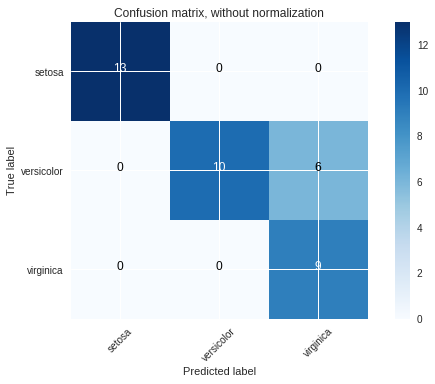

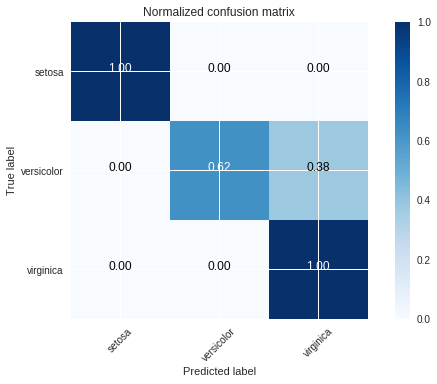

In [5]:

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()